# Определение возраста покупателей

**Описание проблемы**

К вам обратилась компания "Лицехват", для определения возраста в соцсетях по фотографии для дополнительной проверки возраста пользователя. Компания хочет использовать модель машинного обучения для автоматизации проверки на этапе регистрации.

**Цель**

Создать модель ML на основе нейросети для определения возраста. Выбранная метрика MAE. Метрика готовой модели должна быть ниже 8.

**Задачи**
1. Создать загрузчик данных и осмотреть часть датасета.
2. Провести анализ распределения возрастов
3. Создать функции для деления датасета, создания архитектуры и обучения модели
4. Обучить модель
5. Сделать выводы

**Данные**

Датасет и разметка предоставлена Яндекс Практикумом

## Исследовательский анализ данных

**Импорт библиотек**

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

**Импорт данных**

In [2]:
train_label_df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(train_label_df.head(3))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [4]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

In [5]:
data_flow = datagen.flow_from_dataframe(dataframe=train_label_df, directory='/datasets/faces/final_files',
                            x_col="file_name", y_col="real_age", class_mode='raw', batch_size=32)

Found 7591 validated image filenames.


**Размеры датасета**

In [6]:
train_label_df.shape

(7591, 2)

**Распределение возрастов**

Text(0.5, 0, 'Возраст в годах')

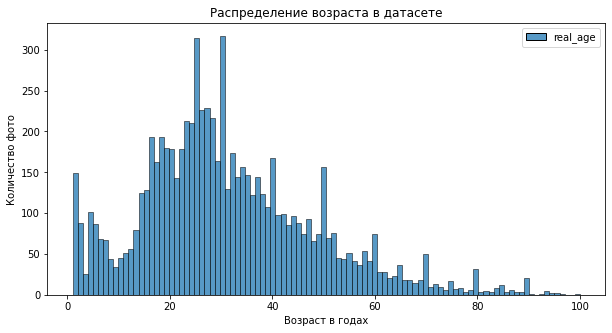

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(data=train_label_df, bins=100)
plt.title('Распределение возраста в датасете')
plt.ylabel('Количество фото')
plt.xlabel('Возраст в годах')

**Вывод**

- Данные распределены в целом нормально, со смещением.
- Есть несколько пиков в районе 25, 30, 40, 50 лет.
- Малочисленные данные в возрасте 10±5 лет
- Так же мало данных о людях после 60 лет
- Качество предсказаний итоговой модели будет зависеть от возраста, вероятно лучше всего модель будет работать на фото людей в возрасте на 15-50 лет.
- Данные похожи на распределение возрастной пирамиды какой-то страны. На рисунке ниже половозрастная пирамида России 2022.
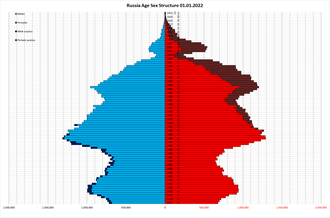

**Примеры фото с возрастом**

In [35]:
features, target = next(data_flow)

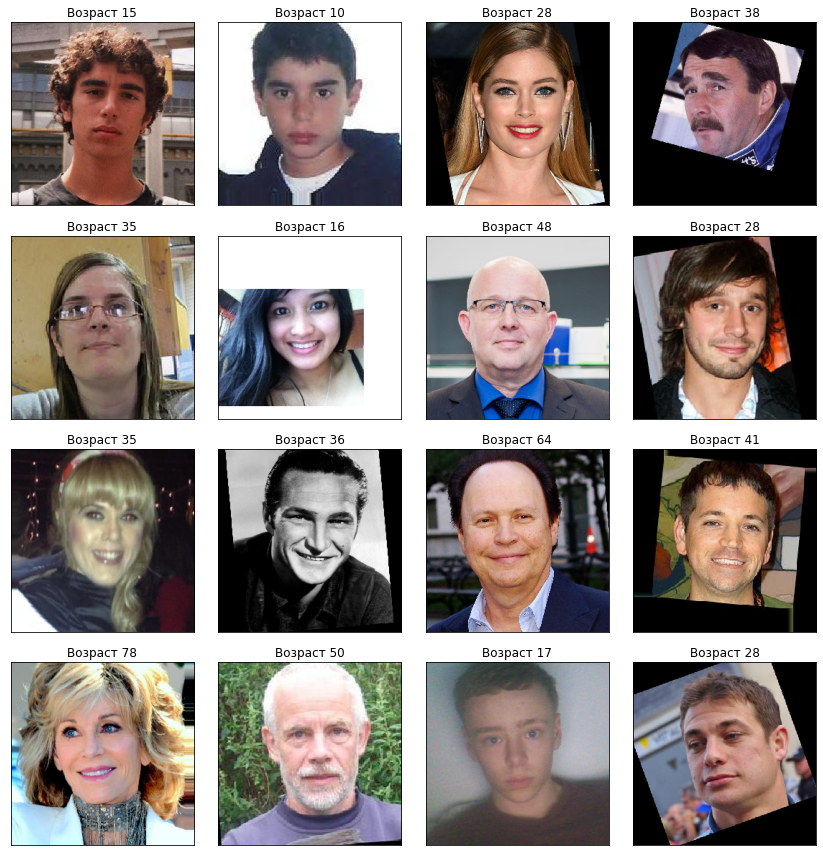

In [36]:
fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст {target[i]} ')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

**Вывод**

- Встречаются черно-белые фото, интересно что там в каналах
- Фотографии в датасете уже повернуты в одинаковое положение
- Яркость на фото выглядит одинаковой
- В целом датасет был подготовлен к работе

## Обучение модели

**Код обучения модели**

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
label_df = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen_flow = datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=label_df,
        x_col="file_name", y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    train_data = train_datagen_flow
    return train_data

def load_test(path):
    test_datagen_flow = datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=label_df,
        x_col="file_name", y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    test_data = test_datagen_flow
    return test_data

# Сеть ResNet50
def create_model(input_shape):

    backbone = ResNet50(input_shape=(150, 150, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0001), loss='mae',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

**Вывод модели**

```
Tesla V100-SXM2-32GB computeCapability: 7.0
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/50
2023-06-20 14:58:22.694481: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-20 14:58:24.731875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 75s - loss: 10.5067 - mae: 10.5069 - val_loss: 16.2568 - val_mae: 16.2483
Epoch 2/50
356/356 - 38s - loss: 7.1885 - mae: 7.1890 - val_loss: 9.1200 - val_mae: 9.1033
Epoch 3/50
356/356 - 38s - loss: 5.9634 - mae: 5.9634 - val_loss: 6.5035 - val_mae: 6.5118
Epoch 4/50
356/356 - 38s - loss: 5.1371 - mae: 5.1369 - val_loss: 6.6145 - val_mae: 6.6250
Epoch 5/50
356/356 - 38s - loss: 4.5689 - mae: 4.5693 - val_loss: 7.5019 - val_mae: 7.5034
Epoch 6/50
356/356 - 38s - loss: 4.1090 - mae: 4.1082 - val_loss: 7.1476 - val_mae: 7.1583
Epoch 7/50
356/356 - 38s - loss: 3.6814 - mae: 3.6812 - val_loss: 6.5058 - val_mae: 6.5063
Epoch 8/50
356/356 - 38s - loss: 3.3991 - mae: 3.3994 - val_loss: 6.3236 - val_mae: 6.3266
Epoch 9/50
356/356 - 38s - loss: 3.2049 - mae: 3.2046 - val_loss: 6.5290 - val_mae: 6.5330
Epoch 10/50
356/356 - 38s - loss: 3.0179 - mae: 3.0182 - val_loss: 6.4910 - val_mae: 6.4969
Epoch 11/50
356/356 - 38s - loss: 2.8162 - mae: 2.8157 - val_loss: 6.5059 - val_mae: 6.5144
Epoch 12/50
356/356 - 38s - loss: 2.7079 - mae: 2.7079 - val_loss: 6.7437 - val_mae: 6.7422
Epoch 13/50
356/356 - 38s - loss: 2.5449 - mae: 2.5449 - val_loss: 6.2998 - val_mae: 6.3033
Epoch 14/50
356/356 - 38s - loss: 2.5089 - mae: 2.5085 - val_loss: 6.0082 - val_mae: 6.0145
Epoch 15/50
356/356 - 38s - loss: 2.4653 - mae: 2.4651 - val_loss: 6.8316 - val_mae: 6.8425
Epoch 16/50
356/356 - 38s - loss: 2.3079 - mae: 2.3079 - val_loss: 6.5644 - val_mae: 6.5666
Epoch 17/50
356/356 - 38s - loss: 2.2570 - mae: 2.2570 - val_loss: 6.1282 - val_mae: 6.1345
Epoch 18/50
356/356 - 38s - loss: 2.2199 - mae: 2.2197 - val_loss: 6.4317 - val_mae: 6.4345
Epoch 19/50
356/356 - 38s - loss: 2.1750 - mae: 2.1752 - val_loss: 5.9886 - val_mae: 5.9926
Epoch 20/50
356/356 - 38s - loss: 2.0839 - mae: 2.0839 - val_loss: 6.0002 - val_mae: 6.0052
Epoch 21/50
356/356 - 38s - loss: 2.0074 - mae: 2.0075 - val_loss: 6.4422 - val_mae: 6.4462
Epoch 22/50
356/356 - 38s - loss: 1.9938 - mae: 1.9938 - val_loss: 6.0422 - val_mae: 6.0467
Epoch 23/50
356/356 - 38s - loss: 2.0077 - mae: 2.0079 - val_loss: 5.9296 - val_mae: 5.9366
Epoch 24/50
356/356 - 38s - loss: 1.8825 - mae: 1.8826 - val_loss: 6.3230 - val_mae: 6.3262
Epoch 25/50
356/356 - 38s - loss: 1.8740 - mae: 1.8740 - val_loss: 6.1105 - val_mae: 6.1081
Epoch 26/50
356/356 - 38s - loss: 1.8543 - mae: 1.8544 - val_loss: 6.1912 - val_mae: 6.1980
Epoch 27/50
356/356 - 38s - loss: 1.8342 - mae: 1.8341 - val_loss: 5.8174 - val_mae: 5.8251
Epoch 28/50
356/356 - 38s - loss: 1.7675 - mae: 1.7675 - val_loss: 5.9712 - val_mae: 5.9762
Epoch 29/50
356/356 - 38s - loss: 1.6973 - mae: 1.6976 - val_loss: 6.0493 - val_mae: 6.0564
Epoch 30/50
356/356 - 38s - loss: 1.6704 - mae: 1.6705 - val_loss: 6.0762 - val_mae: 6.0851
Epoch 31/50
356/356 - 38s - loss: 1.6687 - mae: 1.6687 - val_loss: 6.0602 - val_mae: 6.0647
Epoch 32/50
356/356 - 38s - loss: 1.6112 - mae: 1.6113 - val_loss: 6.2330 - val_mae: 6.2389
Epoch 33/50
356/356 - 38s - loss: 1.6060 - mae: 1.6057 - val_loss: 5.9873 - val_mae: 5.9912
Epoch 34/50
356/356 - 38s - loss: 1.5853 - mae: 1.5855 - val_loss: 6.1552 - val_mae: 6.1618
Epoch 35/50
356/356 - 38s - loss: 1.5315 - mae: 1.5315 - val_loss: 6.2443 - val_mae: 6.2511
Epoch 36/50
356/356 - 38s - loss: 1.5391 - mae: 1.5391 - val_loss: 6.0313 - val_mae: 6.0371
Epoch 37/50
356/356 - 38s - loss: 1.5086 - mae: 1.5085 - val_loss: 5.9288 - val_mae: 5.9337
Epoch 38/50
356/356 - 38s - loss: 1.5055 - mae: 1.5054 - val_loss: 5.9726 - val_mae: 5.9791
Epoch 39/50
356/356 - 39s - loss: 1.4467 - mae: 1.4468 - val_loss: 5.9366 - val_mae: 5.9416
Epoch 40/50
356/356 - 38s - loss: 1.4403 - mae: 1.4403 - val_loss: 6.1917 - val_mae: 6.2011
Epoch 41/50
356/356 - 38s - loss: 1.4018 - mae: 1.4019 - val_loss: 5.9186 - val_mae: 5.9255
Epoch 42/50
356/356 - 38s - loss: 1.3818 - mae: 1.3817 - val_loss: 6.1220 - val_mae: 6.1246
Epoch 43/50
356/356 - 38s - loss: 1.3608 - mae: 1.3608 - val_loss: 6.0041 - val_mae: 6.0115
Epoch 44/50
356/356 - 38s - loss: 1.3470 - mae: 1.3470 - val_loss: 5.9201 - val_mae: 5.9267
Epoch 45/50
356/356 - 38s - loss: 1.2880 - mae: 1.2881 - val_loss: 6.0848 - val_mae: 6.0882
Epoch 46/50
356/356 - 38s - loss: 1.3000 - mae: 1.3001 - val_loss: 5.8216 - val_mae: 5.8274
Epoch 47/50
356/356 - 38s - loss: 1.2710 - mae: 1.2712 - val_loss: 6.1504 - val_mae: 6.1572
Epoch 48/50
356/356 - 39s - loss: 1.2748 - mae: 1.2747 - val_loss: 5.9406 - val_mae: 5.9459
Epoch 49/50
356/356 - 38s - loss: 1.2587 - mae: 1.2587 - val_loss: 6.2190 - val_mae: 6.2248
Epoch 50/50
356/356 - 39s - loss: 1.2269 - mae: 1.2268 - val_loss: 5.8099 - val_mae: 5.8176
119/119 - 10s - loss: 5.8099 - mae: 5.8176

Test MAE: 5.8176
```

## Анализ обученной модели

- Создана модель на основе ResNet50 и она неплохо справляется с задачей
- MAE модели на тестовой выборке после 50 эпох равно 5.82
- Метрика (MAE) модель примерно после 15 эпохи вышла на плато и колебалась в районе 5.8-6.3, вряд ли есть смысл обучать дольше
- Learning rate = 0.0001 в алгоритме Adam улучшил метрику примерно на 30% по сравнению с моделью с Learning rate = 0.001